In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime

import readfunctions as rf
import lmasources as ls
from KTAL.Utils import ctables as ct
from coordinateSystems import GeographicSystem, MapProjection

In [3]:
geo   = GeographicSystem()

## Read in radar analysis

#### And pulling out the radar grid points for plotting later

In [502]:
filename = '/localdata/wind_analysis/sr12noxp_tdvar_2333_var.out'

dataf       = rf.outfile(filename)
r,u,v,w     = dataf.read_data() # These are in z,y,x
lon,lat,alt = dataf.latlon(geo)

rx,ry,rz = dataf.data_grid()
rx       = rx.reshape(np.shape(w))
ry       = ry.reshape(np.shape(w))
rz       = rz.reshape(np.shape(w))

## Corresponding LMA from .dat file

Analysis is at the time listed, every 3 min, so pulling source points for the following 3 minutes

In [503]:
lma_directory = '/home/vanna.chmielewski/analyzedlightning/notgz/'
lma_file = '{0}LYLOUT_{1}0.exported.dat'.format(lma_directory,dataf.time[:3])
lmad = ls.lmafile(lma_file).readfile()

if int(dataf.time[3]) > 7:
    sfi = datetime.datetime(2012,5,29,int(dataf.time[:2]),int(dataf.time[2:])) + datetime.timedelta(minutes=10)
    lma_file2 = '{0}LYLOUT_{1}0.exported.dat'.format(lma_directory,sfi.strftime('%H%M')[:3])
    lmad2 = ls.lmafile(lma_file2).readfile()
    lmad = pd.concat((lmad,lmad2))

Setting limits for selection from the following 3 min and setting station minimum and chi squared maximum

In [504]:
tstart = int(dataf.time[:2])*3600 + int(dataf.time[2:])*60
tend   = tstart + 3*60
mxchi  = 1.0
mnnum  = 7.0

sources = lmad[(lmad['time'] >= tstart)  & (lmad['time'] < tend) & 
               (lmad['chi']  <= mxchi)   & (lmad['num'] >= mnnum)]
psource = sources[sources['charge'] ==  3]
nsource = sources[sources['charge'] == -3]

### Mapping and gridding corresponding to radar grid (in x,y,z)

Plot check for sanity

In [505]:
exs,eys,ezs = geo.toECEF(np.array(sources['lon']),
                         np.array(sources['lat']),
                         np.array(sources['alt']))
projl = MapProjection(projection='laea', lat_0=dataf.lat, lon_0=dataf.lon, alt_0=dataf.alt)
nxs,nys,nzs = projl.fromECEF(exs,eys,ezs)

In [506]:
binz = np.arange(dataf.iz,dataf.nz*dataf.dz+dataf.iz+dataf.dz,dataf.dz)-dataf.dz/2.
biny = np.arange(dataf.iy,dataf.ny*dataf.dy+dataf.iy+dataf.dy,dataf.dy)-dataf.dy/2.
binx = np.arange(dataf.ix,dataf.nx*dataf.dx+dataf.ix+dataf.dx,dataf.dx)-dataf.dx/2.

negs = sources['charge'] == -3
poss = sources['charge'] ==  3
unas = sources['charge'] ==  0
abins = (binx,biny,binz)

all_counts = np.histogramdd(np.array([nxs,nys,nzs]).T,bins=abins)[0]
p_counts   = np.histogramdd(np.array([nxs[poss],nys[poss],nzs[poss]]).T,bins=abins)[0]
n_counts   = np.histogramdd(np.array([nxs[negs],nys[negs],nzs[negs]]).T,bins=abins)[0]

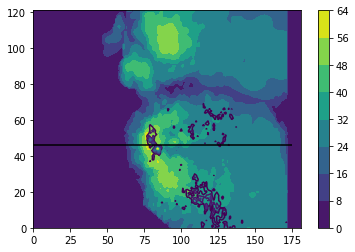

In [509]:
gridcell = 46

plt.contour(np.sum(all_counts,axis=2).T,20)
plt.contourf(r[20])
plt.hlines(gridcell,0,175)
plt.colorbar()

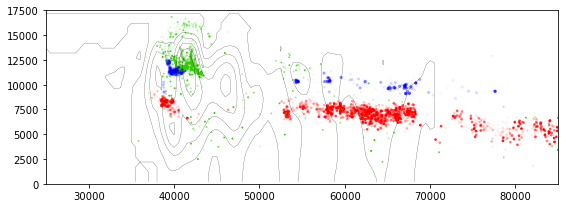

In [510]:
plt.figure(figsize=(8,3))

dist = np.abs(nys-gridcell*dataf.dx)
alpha = np.exp(-dist/400.)

plt.contour(rx[:,gridcell,:],rz[:,gridcell,:],w[:,gridcell,:],colors='k',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nzs[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nzs[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nzs[unas],color=c,edgecolors=c,s=1)

plt.xlim(50*dataf.dx,170*dataf.dx)
plt.ylim(0,17500)
plt.tight_layout()

## Read in flash-sorted grid files

In [511]:
flash_grid_dir = '/localdata/KingfisherAnalysis/flashsort/grid_files/2012/May/29/'

grid_var = {'flash_extent' : 'flash_extent',
            'flash_init' : 'flash_initiation',
            'flashsize_std' : 'flashsize_std',
            'footprint' : 'flash_footprint',
            'source' : 'lma_source',
            'specific_energy' : 'specific_energy',
            'total_energy' : 'total_energy',
           }

In [512]:
flashgrid = xr.Dataset()
for key in grid_var:
    filename = '{0}OKLMA_20120529_{1}000_600_10src_0.0055deg-dx_{2}_3d.nc'.format(flash_grid_dir,dataf.time[:3],key)
    flashgrid = xr.auto_combine((flashgrid,xr.open_dataset(filename)))

#
## This takes WAY too much memory. MUST be a better way
#

# if int(dataf.time[3]) > 7:
#     flashgrid2 = xr.Dataset()
#     sfi = datetime.datetime(2012,5,29,int(dataf.time[:2]),int(dataf.time[2:])) + datetime.timedelta(minutes=10)
#     for key in grid_var:
#         filename = '{0}OKLMA_20120529_{1}000_600_10src_0.0055deg-dx_{2}_3d.nc'.format(flash_grid_dir,sfi.strftime('%H%M')[:3],key)
#         flashgrid2 = xr.auto_combine((flashgrid2,xr.open_dataset(filename)))
# #     flashgrid = xr.concat((flashgrid,flashgrid2),'ntimes',data_vars='minimal')

In [513]:
glo,gla,gal = np.meshgrid(np.array(flashgrid['longitude']),
                          np.array(flashgrid['latitude']),
                          np.array(flashgrid['altitude']))

gexs,geys,gezs = geo.toECEF(glo,gla,gal)
projl = MapProjection(projection='laea', lat_0=dataf.lat, lon_0=dataf.lon, alt_0=dataf.alt)
gnxs,gnys,gnzs = projl.fromECEF(gexs,geys,gezs)

### DLA analysis FORTRAN-array output text files

Same grid as radar analysis, trajectory files are on $\Delta$t by subsetted z,y,x

In [514]:
DLAvariables = ['obqrat','obqclw','obqxlw','obthet','obthetv',
                'obqrlw','obqslw','obqglw']

i = 0
DLA = np.zeros((8,35,122,182))
for vari in DLAvariables:
    testfile = '/localdata/DLA/output/{0}_gto_{1}.txt'.format(vari,dataf.time)
    test = pd.read_csv(testfile,header=None,delim_whitespace=True,na_values=-1000.0)
    DLA[i] = np.array(test).flatten()[:-57].reshape((35,122,182))
    i = i+1

# Matchin up different grids (y-cross section)

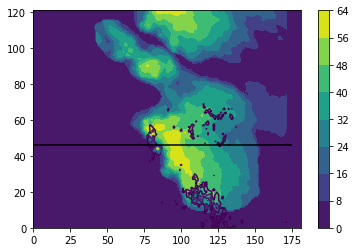

In [640]:
mfrom0 = gridcell*dataf.dx

plt.contour(np.sum(all_counts,axis=2).T,20)
plt.contourf(r[5])
plt.hlines(mfrom0/dataf.dx,0,175)
plt.colorbar()

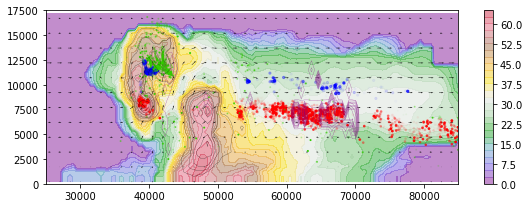

In [516]:
plt.figure(figsize=(8,3))

dist = np.abs(nys-mfrom0)
alpha = np.exp(-dist/400.)

rgrid = int(mfrom0/dataf.dx)
lgrid = np.argmin(np.abs(gnys[:,0,0] - mfrom0))

plt.contourf(rx[:,rgrid,:],rz[:,rgrid,:],r[:,rgrid,:],30,cmap=ct.Carbone11,alpha=0.5)
plt.colorbar()
plt.contour(rx[:,rgrid,:],rz[:,rgrid,:],DLA[7,:,rgrid,:],colors='k',linewidths=0.2)

step=3
plt.quiver(rx[::step,rgrid,::step],rz[::step,rgrid,::step],
            u[::step,rgrid,::step], w[::step,rgrid,::step],
#            headwidth=1,headlength=1,
           scale=2500,
           width=0.001,
           pivot='middle',
          )

plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],np.mean(flashgrid['flash_footprint'][8,:,lgrid-1:lgrid+2,:],axis=1),
            levels=np.arange(5,1500,50),colors='purple',linewidths=0.2)
plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],flashgrid['flash_footprint'][8,:,lgrid,:],colors='purple',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nzs[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nzs[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nzs[unas],color=c,edgecolors=c,s=1)

plt.xlim(50*dataf.dx,170*dataf.dx)
plt.ylim(0,17500)
plt.tight_layout()

### Add in DLA trajectories

In [517]:
tx = pd.read_csv('/localdata/DLA/output/gridxt_gto_{0}.txt'.format(dataf.time),
                 header=None,delim_whitespace=True,na_values='-999.0',skiprows=1)
ty = pd.read_csv('/localdata/DLA/output/gridyt_gto_{0}.txt'.format(dataf.time),
                 header=None,delim_whitespace=True,na_values='-999.0',skiprows=1)
tz = pd.read_csv('/localdata/DLA/output/gridzt_gto_{0}.txt'.format(dataf.time),
                 header=None,delim_whitespace=True,na_values='-999.0',skiprows=1)

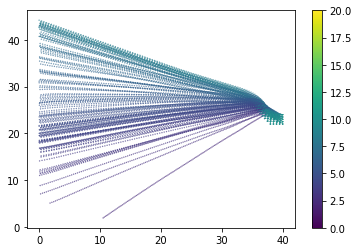

In [557]:
# selects = (tx[0]==85.) & (ty[0]==19) & (tz[0]==9.7)
buffer = 1.0
fx = 39.
fy = 23.
fz = 9.7
selects =   (tx[0]>=(fx-buffer)) & (tx[0]<=(fx+buffer)) & (ty[0]>=(fy-buffer)
        ) & (ty[0]<=(fy+buffer)) & (tz[0]<=(fz+buffer)) & (tz[0]>=(fz-buffer))

plt.scatter(tx.loc[selects],ty.loc[selects],c=tz.loc[selects], s=0.1)
plt.clim(0,20)
plt.colorbar()

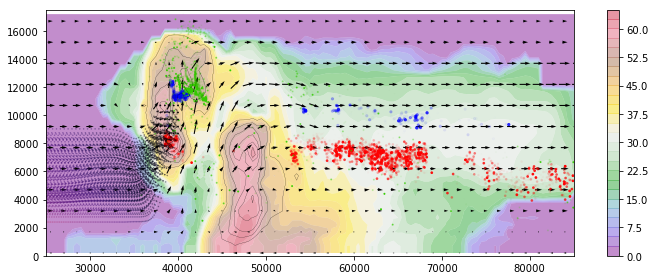

In [558]:
plt.figure(figsize=(10,4))

dist = np.abs(nys-mfrom0)
alpha = np.exp(-dist/400.)

rgrid = int(mfrom0/dataf.dx)
lgrid = np.argmin(np.abs(gnys[:,0,0] - mfrom0)) # Just the closest cross section from flashgrid to the radar grid

plt.contourf(rx[:,rgrid,:],rz[:,rgrid,:],r[:,rgrid,:],30,cmap=ct.Carbone11,alpha=0.5,antialiased=True)
plt.colorbar()
plt.contour(rx[:,rgrid,:],rz[:,rgrid,:],DLA[7,:,rgrid,:],colors='k',linewidths=0.2)

step=3
plt.quiver(rx[::step,rgrid,::step],rz[::step,rgrid,::step],
            u[::step,rgrid,::step], w[::step,rgrid,::step],
#            headwidth=1,headlength=1,
           scale=1500,
           width=0.002,
           pivot='middle',
          )

# plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],np.mean(flashgrid['flash_footprint'][8,:,lgrid-1:lgrid+2,:],axis=1),
#             levels=np.arange(5,1500,50),colors='purple',linewidths=0.2)
# plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],flashgrid['flash_footprint'][8,:,lgrid,:],colors='purple',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nzs[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nzs[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nzs[unas],color=c,edgecolors=c,s=1)

plt.scatter(tx.loc[selects]*1e3,tz.loc[selects]*1e3,
            c=np.zeros_like(tx.loc[selects])+np.arange(151),s=0.2,cmap='magma',alpha=0.5)
#             c=np.abs(ty.loc[selects]*1e3-mfrom0),s=0.2,cmap='magma')

plt.xlim(50*dataf.dx,170*dataf.dx)
plt.ylim(0,17500)
plt.tight_layout()

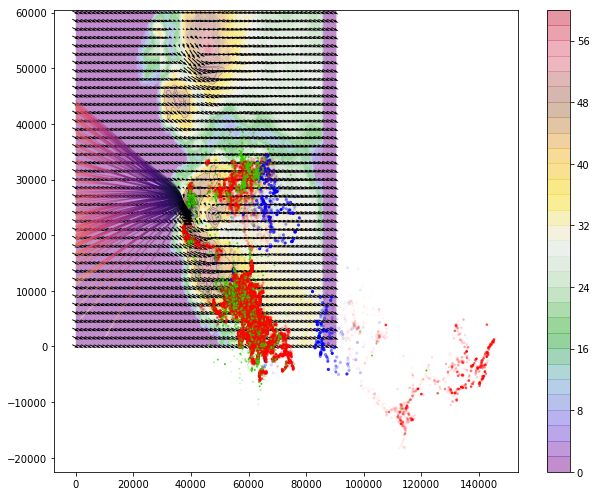

In [627]:
plt.figure(figsize=(9,7))
level = 9.2

dist = np.abs(nzs-level*1e3)
alpha = np.exp(-dist/400.)

rgrid = int((level-0.2)*1e3/dataf.dy)
# lgrid = np.argmin(np.abs(gnys[:,0,0] - mfrom0))

plt.contourf(rx[rgrid,:,:],ry[rgrid,:,:],r[rgrid,:,:],30,cmap=ct.Carbone11,alpha=0.5,antialiased=True)
plt.colorbar()
plt.contour(rx[rgrid,:,:],ry[rgrid,:,:],DLA[7,rgrid,:,:],colors='k',linewidths=0.2)

step=3
plt.quiver(rx[rgrid,::step,::step],ry[rgrid,::step,::step],
            u[rgrid,::step,::step], v[rgrid,::step,::step],
           scale=1500,
           width=0.002,
           pivot='middle',
          )

# Note the flashgrid is 0.2 km off
# plt.contour(gnxs[:,:,rgrid//2],gnys[:,:,rgrid//2],np.mean(flashgrid['flash_footprint'][8,:,:,rgrid//2-1:rgrid//2+2],axis=2).T,
#             levels=np.arange(5,1500,50),colors='purple',linewidths=0.5)
# plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],flashgrid['flash_footprint'][8,:,lgrid,:],colors='purple',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nys[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nys[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nys[unas],color=c,edgecolors=c,s=1)

plt.scatter(tx.loc[selects]*1e3,ty.loc[selects]*1e3,
            c=np.zeros_like(tx.loc[selects])+np.arange(151),s=0.2,cmap='magma',alpha=0.5)
#             c=np.abs(tz.loc[selects]*1e3-mfrom0),s=0.2,cmap='magma')

# plt.xlim(50*dataf.dx,170*dataf.dx)
# plt.ylim(0,40000)
plt.tight_layout()

# yt Plots (and streamline calculations)?

In [325]:
import yt
from yt.visualization.api import Streamlines
from mpl_toolkits.mplot3d import Axes3D

In [521]:
data_test = (dict(u=(u,'m/s'),
                  v=(v,'m/s'),
                  w=(w,'m/s'),
                  dBZ=(r,'mm**6/m**3')))
bbox = np.array([[np.min(rz),np.max(rz)],
                 [np.min(ry),np.max(ry)],
                 [np.min(rx),np.max(rx)]])

hmm = yt.load_uniform_grid(data_test,u.shape,
                    length_unit='m',
                    time_unit='s',
                    velocity_unit='m/s',
                    bbox=bbox,
                    geometry=('cartesian',('z','y','x')))

yt : [INFO     ] 2017-10-31 17:03:17,391 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-10-31 17:03:17,392 Parameters: domain_dimensions         = [ 35 122 182]
yt : [INFO     ] 2017-10-31 17:03:17,394 Parameters: domain_left_edge          = [ 200.    0.    0.]
yt : [INFO     ] 2017-10-31 17:03:17,396 Parameters: domain_right_edge         = [ 17200.  60500.  90500.]
yt : [INFO     ] 2017-10-31 17:03:17,398 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2017-10-31 17:03:20,727 xlim = 250.000000 60750.000000
yt : [INFO     ] 2017-10-31 17:03:20,728 ylim = 200.000000 17200.000000
yt : [INFO     ] 2017-10-31 17:03:20,730 xlim = 250.000000 60750.000000
yt : [INFO     ] 2017-10-31 17:03:20,731 ylim = 200.000000 17200.000000
yt : [INFO     ] 2017-10-31 17:03:20,732 Making a fixed resolution buffer of (('stream', 'dBZ')) 800 by 800



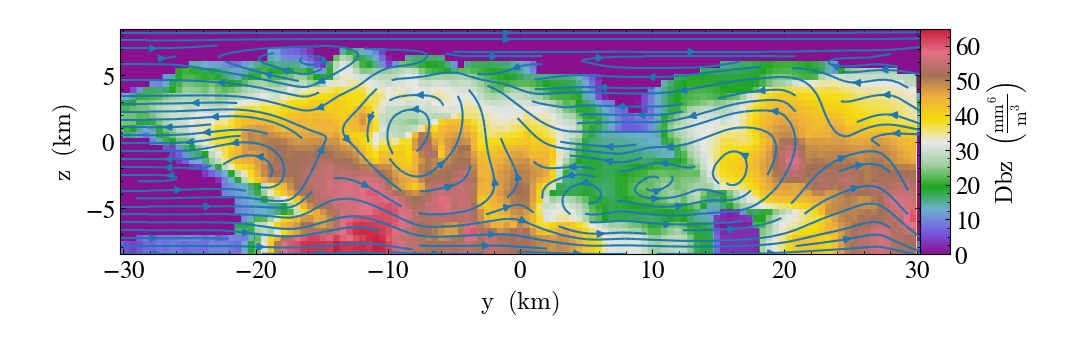

In [522]:
slc = yt.SlicePlot(hmm,'x',['dBZ'],
#                   )
                   center=[8700,30500,50000])

slc.set_log('dBZ',False)
slc.set_cmap('dBZ',ct.Carbone11)
slc.annotate_streamlines('v','w')
slc.show()

In [523]:
starts = np.array([5000,22000,30000]) + np.mgrid[0:10,0:3,0:3].reshape(3,-1).T*[500,1000,1000]

streamlines = Streamlines(hmm,starts,'w', 'v', 'u')
streamlines.integrate_through_volume()

yt : [INFO     ] 2017-10-31 17:04:01,587 AMRKDTree rebuilt, Final Volume: 9.307925e+13
Streamlining: 100%|██████████| 90/90 [00:00<00:00, 204.97it/s]


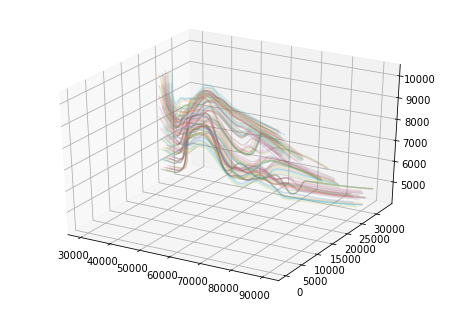

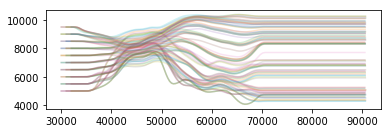

In [553]:
fig=plt.figure()
ax = Axes3D(fig)
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]
    ax.plot3D(stream[:,2], stream[:,1], stream[:,0], alpha=0.2)

fig=plt.figure()
ax = fig.add_subplot(212)
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]
    ax.plot(stream[:,2], stream[:,0], alpha=0.2)

(20000, 50000)

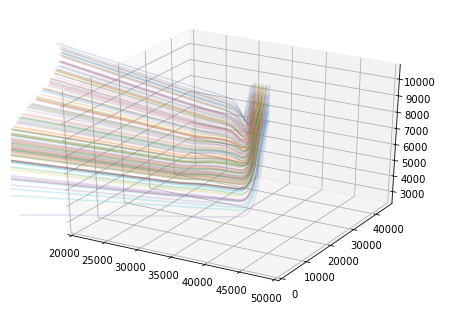

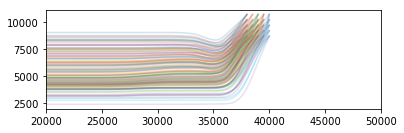

In [563]:
fig=plt.figure()
ax = Axes3D(fig)
# for i in range(5):
for i in range(np.sum(selects)):
    ax.plot3D(np.array(tx.loc[selects])[i]*1e3, 
              np.array(ty.loc[selects])[i]*1e3, 
              np.array(tz.loc[selects])[i]*1e3, alpha=0.2) 
plt.xlim(20000,50000)

fig=plt.figure()
ax = fig.add_subplot(212)
# for i in range(5):
for i in range(np.sum(selects)):
    ax.plot(np.array(tx.loc[selects])[i]*1e3, 
#               np.array(ty.loc[selects])[i]*1e3, 
              np.array(tz.loc[selects])[i]*1e3, alpha=0.2) 
plt.xlim(20000,50000)

In [693]:
from yt.visualization.api import Streamlines
from yt.visualization.volume_rendering.api import Scene, VolumeSource, LineSource
import matplotlib.image as mpimg

yt : [INFO     ] 2017-11-01 15:08:34,789 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-01 15:08:34,794 Creating volume
yt : [INFO     ] 2017-11-01 15:08:35,308 Saving render rendering.png


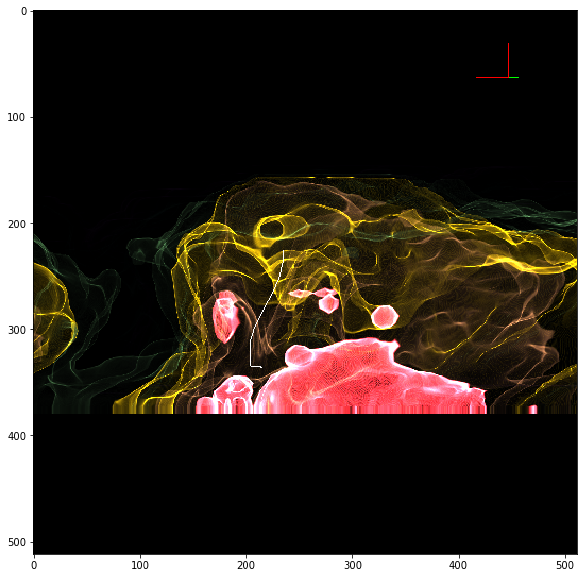

In [751]:
# normal_vector = [0., -0.5, -0.5]
normal_vector = [0., -0.2, -0.7]
north_vector  = [1., 0., 0.]

sc = yt.create_scene(hmm,field='dBZ',lens_type='perspective')
# sc = yt.create_scene(hmm,field=('stream','dBZ'),lens_type='plane-parallel')
source = sc[0]

source.set_field('dBZ')
source.set_log(False)
bounds = (0,60)

camera = sc.add_camera()
camera.set_focus(((8700.,'m'),(22000.,'m'),(38000.,'m')))
# camera.set_focus(((8700.,'m'),(30250.,'m'),(45350.,'m')))
# camera.set_position(((8700.,'m'),(0.,'m'),(20000.,'m')))
# camera.pitch(-np.pi/2)
camera.switch_orientation(normal_vector=normal_vector,
                          north_vector=north_vector)

# Since this rendering is done in log space, the tranfer function needs
# to be specified in log space.
tf = yt.ColorTransferFunction(bounds)
sc.camera.width = (35000,'m')
tf.add_layers(6,colormap=ct.Carbone42)

source.tfh.tf = tf
source.tfh.bounds=bounds
source.tfh.plot('tranfer_function.png',profile_field='dBZ')

# add streamlines
c = hmm.domain_center
N = 100
scale = hmm.domain_width[2]
pos_dx = np.random.random((N,3))*scale-scale/2.
pos = c+pos_dx
sc.annotate_axes(alpha=2)

lines = LineSource(ttest[:50],colors[:50])
# lines = LineSource(ttest, colors)
sc.add_source(lines)

sc.save('rendering.png',sigma_clip=0.001)
plt.figure(figsize=(10,10))
img = mpimg.imread('rendering.png')
plt.imshow(img)

In [750]:
ttest = np.zeros((150,2,3))
ttest[:,0,2] = np.array(tx.loc[selects])[-1,:-1]
ttest[:,1,2] = np.array(tx.loc[selects])[-1,1:]
ttest[:,0,1] = np.array(ty.loc[selects])[-1,:-1]
ttest[:,1,1] = np.array(ty.loc[selects])[-1,1:]
ttest[:,0,0] = np.array(tz.loc[selects])[-1,:-1]
ttest[:,1,0] = np.array(tz.loc[selects])[-1,1:]
ttest = ttest * 1000. * yt.units.m

colors = np.ones((150,4))*np.array([1,1,1,0.01])

yt : [INFO     ] 2017-11-01 15:16:49,744 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-01 15:16:49,751 Creating volume
/localdata/anaconda3/lib/python3.6/site-packages/yt/utilities/amr_kdtree/amr_kdtree.py:311: RuntimeWarning: divide by zero encountered in log10
  dds.append(np.log10(vcd[field].astype('float64')))
/localdata/anaconda3/lib/python3.6/site-packages/yt/utilities/amr_kdtree/amr_kdtree.py:311: RuntimeWarning: invalid value encountered in log10
  dds.append(np.log10(vcd[field].astype('float64')))
yt : [INFO     ] 2017-11-01 15:16:49,802 Creating transfer function
yt : [INFO     ] 2017-11-01 15:16:49,804 Calculating data bounds. This may take a while.  Set the TranferFunctionHelper.bounds to avoid this.
yt : [INFO     ] 2017-11-01 15:16:50,287 Saving render rendering.png


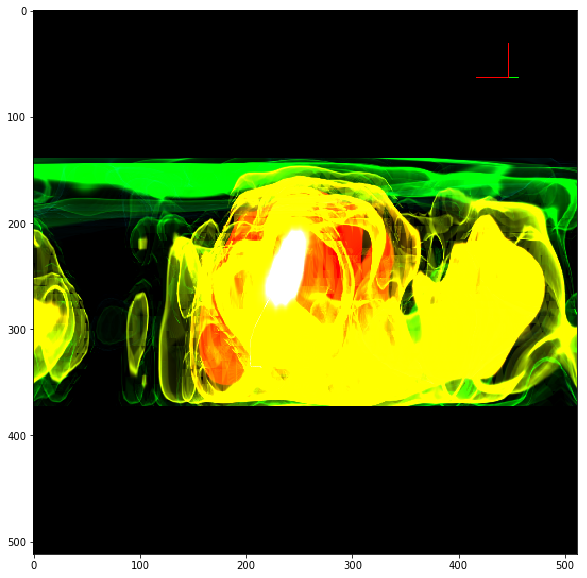

In [759]:
# normal_vector = [0., -0.5, -0.5]
normal_vector = [0., -0.2, -0.7]
north_vector  = [1., 0., 0.]

sc = yt.create_scene(hmm,field=('stream','w'),lens_type='perspective')
# sc = yt.create_scene(hmm,field=('stream','dBZ'),lens_type='plane-parallel')
source = sc[0]

# source.set_field('dBZ')
# source.set_log(False)
# bounds = (0,60)

camera = sc.add_camera()
camera.set_focus(((8700.,'m'),(22000.,'m'),(38000.,'m')))
# camera.set_focus(((8700.,'m'),(30250.,'m'),(45350.,'m')))
# camera.set_position(((8700.,'m'),(0.,'m'),(20000.,'m')))
# camera.pitch(-np.pi/2)
camera.switch_orientation(normal_vector=normal_vector,
                          north_vector=north_vector)

# Since this rendering is done in log space, the tranfer function needs
# to be specified in log space.
tf = yt.ColorTransferFunction(bounds)
sc.camera.width = (35000,'m')
tf.add_layers(4)

# source.tfh.tf = tf
# source.tfh.bounds=bounds
# source.tfh.plot('tranfer_function.png',profile_field='w')

# add streamlines
c = hmm.domain_center
N = 100
scale = hmm.domain_width[2]
pos_dx = np.random.random((N,3))*scale-scale/2.
pos = c+pos_dx
sc.annotate_axes(alpha=2)

lines = LineSource(ttest[:50],colors[:50])
# lines = LineSource(ttest, colors)
sc.add_source(lines)

sc.save('rendering.png',sigma_clip=0.01)
plt.figure(figsize=(10,10))
img = mpimg.imread('rendering.png')
plt.imshow(img)

In [754]:
hmm.field_list

[('stream', 'dBZ'), ('stream', 'u'), ('stream', 'v'), ('stream', 'w')]

### Read in h5 flash files

Just in case these become more important later

In [152]:
filename = '/localdata/KingfisherAnalysis/flashsort/h5_files/2012/May/29/LYLOUT_120529_{0}000_0600.exported.dat.flash.h5'.format(dataf.time[:3])

sources = pd.read_hdf(filename,'events/LMA_120529_{0}000_600'.format(dataf.time[:3]))
flashes = pd.read_hdf(filename,'flashes/LMA_120529_{0}000_600'.format(dataf.time[:3]))

if int(dataf.time[3]) > 7:
    sfi = datetime.datetime(2012,5,29,int(dataf.time[:2]),int(dataf.time[2:])) + datetime.timedelta(minutes=10)
    file2 = '/localdata/KingfisherAnalysis/flashsort/h5_files/2012/May/29/LYLOUT_120529_{0}000_0600.exported.dat.flash.h5'.format(sfi.strftime('%H%M')[:3])
    sources2 = pd.read_hdf(file2,'events/LMA_120529_{0}000_600'.format(sfi.strftime('%H%M')[:3]))
    flashes2 = pd.read_hdf(file2,'flashes/LMA_120529_{0}000_600'.format(sfi.strftime('%H%M')[:3]))
    sources = pd.concat((sources,sources2))
    flashes = pd.concat((flashes,flashes2))

### Fiddling with flash grid files

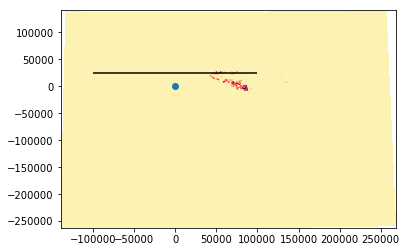

In [40]:
lev = 8
hlev = 571

# plt.contourf(glo[:,:,0],gla[:,:,0],flashgrid['lma_source'][8:10].sum(axis=(0,3)).T,30,cmap='magma_r')
# plt.contourf(flashgrid['longitude'],flashgrid['latitude'],flashgrid['lma_source'][8].sum(axis=2).T,20,cmap='magma_r')
plt.contourf(gnxs[:,:,lev],gnys[:,:,lev],flashgrid['lma_source'][8,:,:,lev].T,20,cmap='magma_r')
plt.hlines(gnys[hlev,0,0],-100000,100000)
plt.scatter(0,0)

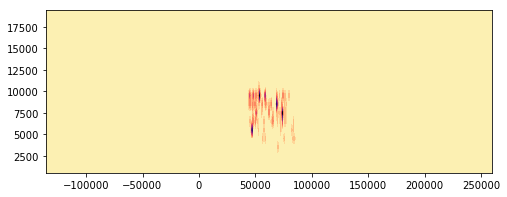

In [64]:
plt.figure(figsize=(8,3))
plt.contourf(gnxs[hlev,:,:],gnzs[hlev,:,:],flashgrid['lma_source'][8,:,hlev,:],20,cmap='magma_r')
# plt.contourf(gnxs[hlev,:,:],gnzs[hlev,:,:],flashgrid['lma_source'][8,:,hlev,:],20,cmap='magma_r')
# plt.contourf(flashgrid['lma_source'][8,:,hlev,:].T,20,cmap='magma_r')
# plt.xlim(50*dataf.dx,170*dataf.dx)
# plt.ylim(0,17500)

#### Other testing

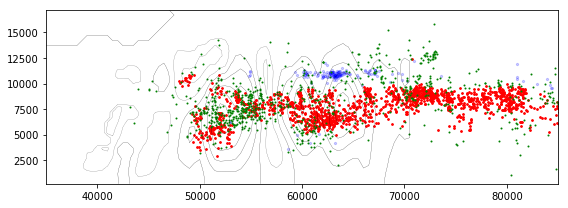

In [118]:
plt.figure(figsize=(8,3))

# gridcell = 60
depth    =  5

plt.contour(rx[:,gridcell,:],rz[:,gridcell,:],w[:,gridcell,:],colors='k',linewidths=0.2)

c = 'b'
selection = (negs) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=5,alpha=0.2)
c = 'r'
selection = (poss) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=3)
c = 'g'
selection = (unas) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=1)

plt.xlim(70*dataf.dx,170*dataf.dx)
plt.tight_layout()

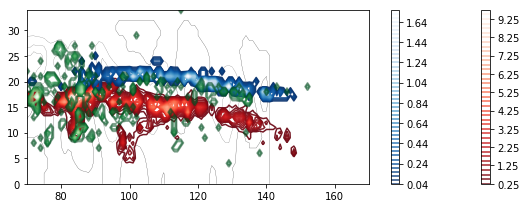

In [14]:
plt.figure(figsize=(8,3))

plt.contour(w[:,gridcell,:],colors='k',linewidths=0.2)

# plt.contour(np.ma.sum(all_counts[:,gridcell-depth:gridcell+depth],axis=1).T,colors='k',linewidths=0.1)
plt.contour(np.sum(p_counts[:,gridcell-depth:gridcell+depth],axis=1).T/depth,40,cmap='Reds_r',alpha=0.9)
plt.colorbar()
plt.contour(np.sum(n_counts[:,gridcell-depth:gridcell+depth],axis=1).T/depth,50,cmap='Blues_r',alpha=0.9)
plt.colorbar()
plt.contour(np.sum(all_counts[:,gridcell-depth:gridcell+depth],axis=1).T-
            np.sum(p_counts[:,gridcell-depth:gridcell+depth],axis=1).T-
            np.sum(n_counts[:,gridcell-depth:gridcell+depth],axis=1).T,30,cmap='Greens_r', alpha=0.5)

plt.xlim(70,170)
plt.tight_layout()

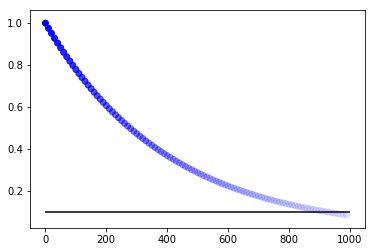

In [119]:
dist = np.arange(0.1,1000,10)
# alpha = 100./(dist)
alpha = np.exp(-dist/400.)
# alpha[alpha>1] = 1

c = np.asarray([(0,0,1,a) for a in alpha])
plt.scatter(dist,alpha,color=c,edgecolors=c)
plt.hlines(0.1,0,1000)

#### To be very specific about the trajectory from the DLA and make sure I understand how the output file is set up

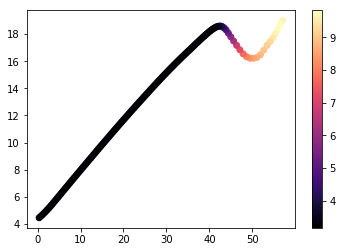

In [179]:
zt,yt,xt = 35,91,141 # total number of dimensions in each
xl,yl,zl = 57.,19.,9.7 # desired location (km) wrt radar origin
zg = (zl-0.2)/0.5 # location wrt traj subset grid
yg = (yl-5.0)/0.5
xg = (xl-15.)/0.5
gridloc = zg*yt*xt + yg*xt + xg # where it sits in the array
plt.scatter(tx.loc[gridloc],ty.loc[gridloc],c=tz.loc[gridloc],cmap='magma')
plt.colorbar()